In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import rubin_sim.maf as maf
import rubin_sim.photUtils as photUtils
from rubin_sim.site_models import SeeingModel
import syseng_throughputs as st

In [2]:
# This is the same as calcM5 from syseng_throughputs BUT replaced pandas dataframes with dicts and removes some 
# unneeded (here) calculations.

def calcM5(hardware, system, darksky=None, sky_mags=None,
           exptime=15, nexp=2,
           readnoise=8.8, othernoise=0, darkcurrent=0.2,
           effarea=np.pi*(6.423/2*100)**2, X=1.0, fwhm500=None):
    """Calculate values which are related to m5 (basically 'table2' of overview paper).
    Parameters
    ----------
    hardware : `dict` of `Bandpass`
        The bandpasses for the hardware only.
    system : `dict` of `Bandpass`
        The bandpasses for the total system (hardware + atmosphere)
    darksky : `Sed` or None
        The Sed of the dark night sky.
        Default None, in which case it will be read from $SYSENG_THOUGHPUTS_DIR/siteProperties/darksky.dat
    sky_mags : `dict` of `float` ot None
        The magnitudes for the skybackground to use. If "None", then uses default values
        that are derived from the darksky SED (which is properly normalized in this siteProperties directory).
    exptime : `float`, opt
        The open-shutter exposure time for one exposure (seconds). Default 15s.
    nexp : `int`, opt
        The number of exposures in one visit. Default 2.
    readnoise : `float`, opt
        The readnoise for one exposure (electrons). Default 8.8 e-
    othernoise : `float`, opt
        Additional noise to be handled like readnoise (electrons). Default 0.
    darkcurrent : `float`, opt
        Dark current (electrons/second). Default 0.2 e-/s.
    effarea : `float`, opt
        Effective area of the primary mirror (cm^2). Default pi*(6.432/2 m)**2
    X : `float`, opt
        The airmass for the system bandpasses. Used to modify FWHMeff and Cm values.
         Default 1.0.
    fwhm_500 : `float` or None, opt
        fwhm_500 value, in arcseconds, to input into lsst seeing model.
        Default of None uses fiducial values from rubin_sim.photUtils.LSSTdefaults, corresponding to
        "fiducial values" for comparison to SRD (best at X=1).
        A value of 0.62", run through the rubin_sim.site_models.SeeingModel closely recreates these values,
        although note exactly. A value of 0.72" recreates approximate simulation median values of IQ.
    Returns
    -------
    pd.DataFrame
        Dataframe containing a variety of useful information about m5 and other values.
    """
    # PhotometricParameters object for "real" visit.
    photParams_std = photUtils.PhotometricParameters(exptime=exptime, nexp=nexp,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)
    # PhotometricParameters object for "no noise" visit.
    photParams_infinity = photUtils.PhotometricParameters(exptime=exptime, nexp=nexp,
                                                gain=1.0, readnoise=0, darkcurrent=0,
                                                othernoise=0, effarea=effarea)
    
    # Set up dark sky and flat seds.
    if darksky is None:
        rootDir = st.findRootDir()
        darksky = photUtils.Sed()
        darksky.readSED_flambda(os.path.join(rootDir,
                                             'siteProperties', 'darksky.dat'))

    flatSed = photUtils.Sed()
    flatSed.setFlatSED()

    # Now set up dataframe. filters x properties.
    properties = ['FWHMeff', 'skyMag', 'kAtm',
                  'Cm', 'dCm_infinity', 'm5']
    d = {}
    for k in properties:
        d[k] = {}

    # Set filterlist - usually this will be just 'filterlist' above, but could have added extras
    for f in system:
        if f not in filterlist:
            filterlist.append(f)

    # Calculate the FWHM at each wavelength, for this airmass.
    seeing_model = SeeingModel()
    fwhm_eff = dict(zip(filterlist, seeing_model(fwhm500, X)['fwhmEff']))

    # Make a copy of the dark sky SED and so we can renormalize per band for 'right' skybackground
    sky = photUtils.Sed()
    sky.setSED(wavelen=darksky.wavelen, flambda=darksky.flambda)
    
    for f in system:
        # Let's make this simple
        d['FWHMeff'][f] = fwhm_eff[f]
        if sky_mags is not None:
            fluxNorm = sky.calcFluxNorm(sky_mags[f], hardware[f])
            sky.multiplyFluxNorm(fluxNorm)
            d['skyMag'][f] = sky.calcMag(hardware[f])
        else:
            d['skyMag'][f] = sky.calcMag(hardware[f])
        d['m5'][f] = photUtils.SignalToNoise.calcM5(sky, system[f], hardware[f],
                                                    photParams_std, 
                                                    FWHMeff=d['FWHMeff'][f])
        # Calculate Cm_Infinity by setting readout noise to zero.
        m5inf = photUtils.SignalToNoise.calcM5(sky, system[f], hardware[f],  
                                               photParams_infinity,
                                               FWHMeff=d['FWHMeff'][f])
        # Calculate kAtm
        dwavelen = np.mean(np.diff(system[f].wavelen))
        Tb = np.sum(system[f].sb / system[f].wavelen) * dwavelen
        # Calculate the "Sigma" 'system integral' (this is the hardware only)
        Sb = np.sum(hardware[f].sb / hardware[f].wavelen) * dwavelen
        # Calculate km - atmospheric extinction in a particular bandpass
        d['kAtm'][f] = -2.5 * np.log10(Tb / Sb)
        # Calculate the Cm and Cm_Infinity values.
        # m5 = Cm + 0.5*(msky - 21) + 2.5log10(0.7/FWHMeff) + 1.25log10(t/30) - km(X-1.0)
        # Assumes atmosphere used in system throughput is X=1.0
        d['Cm'][f] = (d['m5'][f] - 0.5 * (d['skyMag'][f] - 21) - 2.5 * np.log10(0.7 / d['FWHMeff'][f])
                       - 1.25 * np.log10((photParams_std.exptime * photParams_std.nexp) / 30.0)
                       + d['kAtm'][f] * (X - 1.0))
        Cm_infinity = (m5inf - 0.5 * (d['skyMag'][f] - 21) - 2.5 * np.log10(0.7 / d['FWHMeff'][f])
                       - 1.25 * np.log10((photParams_infinity.exptime * photParams_infinity.nexp) / 30.0)
                       + d['kAtm'][f] * (X - 1.0))
        d['dCm_infinity'][f] = Cm_infinity - d['Cm'][f]

    d = pd.DataFrame(d, index=filterlist)
    return d

In [3]:
defaultdirs = st.setDefaultDirs()
defaultdirs

{'detector': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/detector/joint_minimum',
 'lens1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens1',
 'lens2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens2',
 'lens3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens3',
 'filters': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/filters',
 'mirror1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror1',
 'mirror2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror2',
 'mirror3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror3',
 'atmosphere': '/Users/lynnej/lsst_repos/syseng_throughputs/siteProperties'}

In [4]:
# Read dark sky and X=1 atmosphere (default is to use X=1.2 atmosphere otherwise)
darksky = photUtils.Sed()
darksky.readSED_flambda(os.path.join(st.findRootDir(), 'siteProperties', 'darksky.dat'))
atmosphere = st.readAtmosphere(defaultdirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')

# READ WITHOUT ANY SYSTEM LOSSES
hardware, system = st.buildHardwareAndSystem(defaultdirs, atmosphereOverride=atmosphere, addLosses=False)

In [5]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
# Set up PhotometricParameters object - which stores readnoise, etc
readnoise = 8.8 # e-/read
darkcurrent = 0.2 # e-/s
photParameters_15 = photUtils.PhotometricParameters(exptime=15, nexp=2, gain=1, 
                                                     readnoise=readnoise, othernoise=0, darkcurrent=darkcurrent)
photParameters_30 = photUtils.PhotometricParameters(exptime=30, nexp=1, gain=1,
                                                   readnoise=readnoise, othernoise=0, darkcurrent=darkcurrent)
# Make it easier to retrieve the appropriate version per-bandpass
photParams = {}
photParams['u'] = photParameters_30
for f in ('g', 'r', 'i', 'z', 'y'):
    photParams[f] = photParameters_15

In [6]:
# Look at range of exposure times: how does Cm vary? And does dCm match? 

In [7]:
fwhm500 = 0.62
X=1
# sky values = darksky

texp = np.concatenate((np.arange(1, 50, 1), np.arange(50, 100, 2)))
idx = np.where(texp == 30)

Cm = {}
for f in filterlist:
    Cm[f] = np.zeros(len(texp))
    for i, t in enumerate(texp):
        tmp = calcM5(hardware, system, darksky, sky_mags=None, exptime=t, nexp=1, fwhm500=fwhm500, X=X)
        Cm[f][i] = tmp.loc[f]['Cm']

Text(0, 0.5, 'Cm')

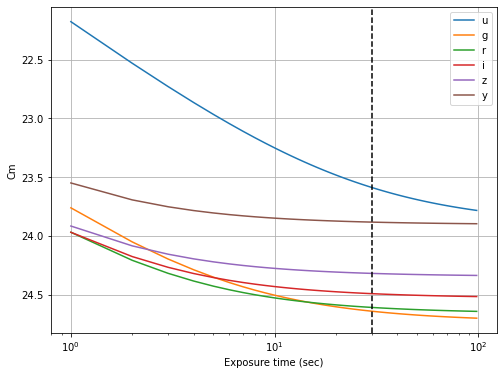

In [8]:
plt.figure(figsize=(8,6))
for f in filterlist:
    plt.plot(texp, Cm[f], label=f)
plt.axvline(30, color='k', linestyle='--')
plt.grid()
plt.legend()
plt.xscale('log')
ylims = plt.ylim()
plt.ylim(ylims[1], ylims[0])
plt.xlabel('Exposure time (sec)')
plt.ylabel("Cm")

In [9]:
skyrange= {}
skyrange['u'] = np.arange(20, 23, .1)
skyrange['g'] = np.arange(17, 22.5, .1)
skyrange['r'] = np.arange(17., 21.5, .1)
skyrange['i'] = np.arange(17, 20.5, .1)
skyrange['z'] = np.arange(16.5, 22, .1)
skyrange['y'] = np.arange(16, 19, .1)

skycopy = photUtils.Sed()
skycopy.readSED_flambda(os.path.join(defaultdirs['atmosphere'], 'darksky.dat'))

Cm = {}
for f in filterlist:
    Cm[f] = np.zeros(len(skyrange[f]))
    for i, sky in enumerate(skyrange[f]):
        # Set the skybackground in our filter of interest to the current 'sky' value
        fluxNorm = skycopy.calcFluxNorm(sky, hardware[f])
        skycopy.multiplyFluxNorm(fluxNorm)
        tmp = calcM5(hardware, system, skycopy, sky_mags=None, exptime=30, nexp=1, fwhm500=fwhm500, X=X)
        Cm[f][i] = tmp.loc[f]['Cm']

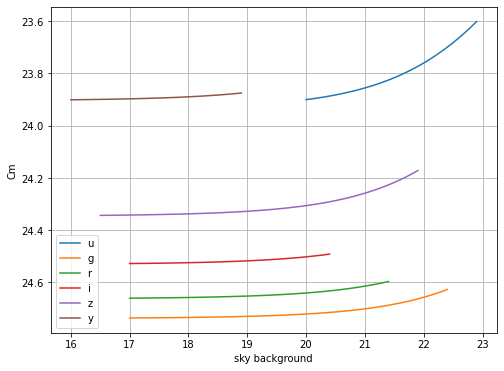

In [10]:
plt.figure(figsize=(8,6))
for f in filterlist:
    plt.plot(skyrange[f], Cm[f], label=f)
plt.legend()
ylims = plt.ylim()
plt.ylim(ylims[1], ylims[0])
plt.xlabel('sky background')
plt.ylabel("Cm")
plt.grid()

In [11]:
X=1
# sky values = darksky

fwhm500_range = np.arange(0.45, 0.75, 0.02)

Cm = {}
for f in filterlist:
    Cm[f] = np.zeros(len(fwhm500_range))
    for i, s in enumerate(fwhm500_range):
        tmp = calcM5(hardware, system, darksky, sky_mags=None, exptime=30, nexp=1, fwhm500=s, X=X)
        Cm[f][i] = tmp.loc[f]['Cm']

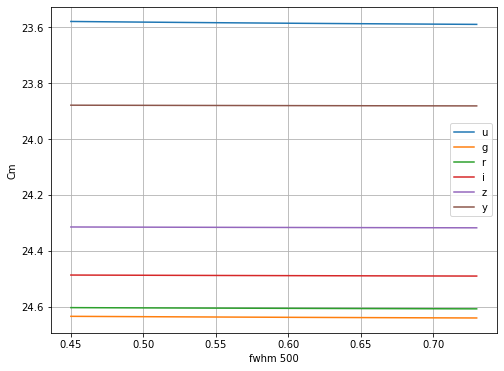

In [12]:
plt.figure(figsize=(8,6))
for f in filterlist:
    plt.plot(fwhm500_range, Cm[f], label=f)
plt.legend()
ylims = plt.ylim()
plt.ylim(ylims[1], ylims[0])
plt.xlabel('fwhm 500')
plt.ylabel("Cm")
plt.grid()

In [13]:
fwhm500 = 0.62
# sky values = darksky

X_range = np.arange(1, 2.5, .1)

Cm = {}
for f in filterlist:
    Cm[f] = np.zeros(len(X_range))
    for i, x in enumerate(X_range):
        tmp = calcM5(hardware, system, darksky, sky_mags=None, exptime=30, nexp=1, fwhm500=fwhm500, X=x)
        Cm[f][i] = tmp.loc[f]['Cm']

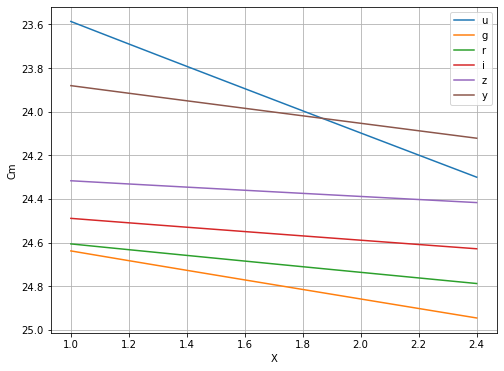

In [14]:
plt.figure(figsize=(8,6))
for f in filterlist:
    plt.plot(X_range, Cm[f], label=f)
plt.legend()
ylims = plt.ylim()
plt.ylim(ylims[1], ylims[0])
plt.xlabel('X')
plt.ylabel("Cm")
plt.grid()

In [15]:
atmosfiles = [a for a in os.listdir('/Users/lynnej/rubin_sim_data/throughputs/atmos') 
              if 'aerosol.dat' in a and 'water' not in a]
atmosfiles

['atmos_16_aerosol.dat',
 'atmos_24_aerosol.dat',
 'atmos_13_aerosol.dat',
 'atmos_21_aerosol.dat',
 'atmos_22_aerosol.dat',
 'atmos_10_aerosol.dat',
 'atmos_19_aerosol.dat',
 'atmos_15_aerosol.dat',
 'atmos_20_aerosol.dat',
 'atmos_12_aerosol.dat',
 'atmos_25_aerosol.dat',
 'atmos_17_aerosol.dat',
 'atmos_14_aerosol.dat',
 'atmos_18_aerosol.dat',
 'atmos_11_aerosol.dat',
 'atmos_23_aerosol.dat']

In [16]:
X_range = np.arange(1, 2.6, .1)
Cm = {}
for f in filterlist:
    Cm[f] = np.zeros(len(X_range))
for i, x in enumerate(X_range):
    xn = f'{x:.1f}'.replace('.', '')
    filename = f'atmos_{xn}_aerosol.dat'
    atmosphere = st.readAtmosphere('/Users/lynnej/rubin_sim_data/throughputs/atmos', atmosFile=filename)
    # READ WITHOUT ANY SYSTEM LOSSES
    hardware, system = st.buildHardwareAndSystem(defaultdirs, atmosphereOverride=atmosphere, addLosses=False)
    tmp = calcM5(hardware, system, darksky, sky_mags=None, exptime=30, nexp=1, fwhm500=fwhm500, X=x)
    for f in filterlist:
        Cm[f][i] = tmp.loc[f]['Cm']

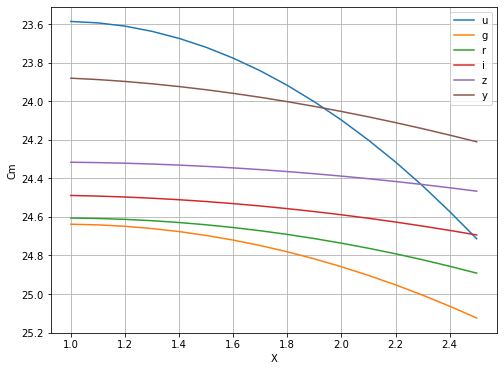

In [17]:
plt.figure(figsize=(8,6))
for f in filterlist:
    plt.plot(X_range, Cm[f], label=f)
plt.legend()
ylims = plt.ylim()
plt.ylim(ylims[1], ylims[0])
plt.xlabel('X')
plt.ylabel("Cm")
plt.grid()